In [1]:
# # # using ULMFIT to classify tweets # # #

# first importing needed libraries
from fastai.text import *


In [2]:
# path to twitter data
path='/home/roope/projects/sort-by-sentiment/training-data/'

In [114]:
# putting the data into dataframe and checking first 5 rows
data = pd.read_csv(path + 'Sentiment Analysis Dataset.csv', error_bad_lines=False)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


In [115]:
data.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [116]:
# SOME INITIAL DATA PREPROCESSING 

# removing whitespace 
data['SentimentText'] = data['SentimentText'].apply(str.strip)

# shuffling the data
data = data.reindex(np.random.permutation(data.index))



In [117]:
# removing unneeded columns
data.drop(['ItemID', 'SentimentSource'], axis=1, inplace=True)

In [119]:
data.head()

,Sentiment,SentimentText
1437688,0,I don't think we can do our picnic
951105,1,I'm with my steph buddy and we're so happy no...
745349,1,"Haha, I wonder how many followers THAT gets me."
1262851,0,There isn't going to be anything happening for...
1053455,0,@meln4 insanely....everyone is out and the boy...


In [21]:
# for speed and testing purposes, only using 50000 examples from the data
# data = data[0:50000]

In [121]:
# saving as csv, the full dataset
data.to_csv(path + 'Sentiment Analysis Dataset-full.csv',index=False)

In [22]:
# saving as csv, the 50 000 example data, for future use
data.to_csv(path + 'Sentiment Analysis Dataset-50k.csv')

In [ ]:
# # # training language model with the tweets # # #

In [ ]:
# using batch size to make model to fit into gpu

In [122]:
bs = 60

In [127]:
# For langugage model training putting this data into TextDataBunch
data_lm = (TextList.from_csv(path, 'Sentiment Analysis Dataset-full.csv', cols='SentimentText')
        .split_by_rand_pct(valid_pct=0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs))

In [128]:
# saving the datamodel
data_lm.save('data_twitter_lm.pkl')

In [3]:
#loading the data
data_lm = load_data(path, 'data_twitter_lm.pkl',bs=64)

In [130]:
# looking up the processed data (tokenized)
data_lm.show_batch()

idx,text
0,yet- this is just a warning for all you dying of boredom ! - sorry ! xxbos @meln4 insanely xxrep 4 . everyone is out and the boys have n't twittered in xxup ages lol xxbos fuck your titties that is all . xxbos new record ! ! ! xxunk ! ! ! xxbos serious xxunk events forms xxup .net work this evening . xxmaj no xxmaj judo xxbos iphone
1,xxmaj gina . xxmaj it 's the next best thing to being there xxbos xxmaj why do u need a xxmaj board to control stock exchange movement ? y o xxmaj god y ? ? ? xxmaj and y do i have to read abt it ? y o xxmaj god y ? ? ? xxbos xxmaj bears won and now one of my best friends xxmaj connor boo is
2,"any relief . xxmaj hope it works for you xxbos pens what happened tonight xxbos it 's so funny , that we ca n't see our pics . after work , i 'll try it again , with a xxunk pic of me . xxbos xxmaj no xxunk , but xxmaj cards lost xxbos @monkeyknopfler xxmaj thanks for that ! i could contact xxunk could n't xxup i. xxmaj is"
3,xxbos xxmaj another day wasted with learning for my exam xxmaj could use a break soon . xxbos welcomes new followers & & looks forward to their updates xxunk ™ s connect @ xxup fb http : / / bit.ly / xxunk xxbos xxmaj cleaning and packing up my bedroom ... xxmaj seems like a huge job ... i have 2 1 / 2 weeks to get it done though
4,trans .. xxmaj huhuhu .. xxmaj xxunk .. xxbos wow . i just install twitter fox . i am tired to keep refresh my browser xxbos xxunk some wishing they were in xxmaj austin ! xxbos @milagro88 some local resort . xxmaj nothing spectacular xxbos xxunk i have always loved them .. just stuck out of control on and it makes me miss tour xxbos xxunk xxup yay xxmaj hoping


In [7]:
# language model learner
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) 

In [5]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


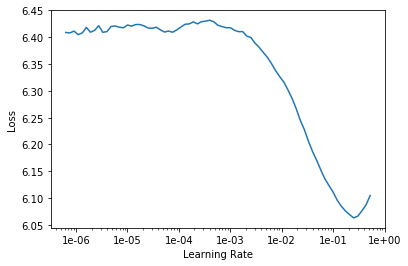

In [6]:
# checking what appropriate learning rate is
learn.recorder.plot(skip_end=15)

In [7]:
# fitting one cycle
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.570214,4.409969,0.238966,28:19


In [8]:
# saving after first cycle
learn.save('fit_head')

In [8]:
learn.load('fit_head')
# the model structure printed

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1420751 items)
x: LMTextList
xxbos i do n't think we can do our picnic,xxbos i 'm with my steph buddy and we 're so happy not even june and summer already xxup rocks ! xxmaj that and the moon looks amazing look at that . ...,xxbos xxmaj haha , i wonder how many followers xxup that gets me .,xxbos xxmaj there is n't going to be anything happening for some time yet- this is just a warning for all you dying of boredom ! - sorry !,xxbos @meln4 insanely xxrep 4 . everyone is out and the boys have n't twittered in xxup ages lol
y: LMLabelList
,,,,
Path: /home/roope/projects/sort-by-sentiment/training-data;

Valid: LabelList (157861 items)
x: LMTextList
xxbos watching the second part of the xxmaj google xxmaj wave demo video . xxmaj in the garden , in the sun , xxup hd quality video , in a lazy chair,xxbos xxunk every time i do my computer says thers been an error ...,xxbos been at home the whole day so bored !,xxbos uploading pictures 

In [9]:
# completing the language model finetuning (10 epochs)
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.502719,4.403286,0.239607,28:23
1,4.514668,4.398929,0.239931,28:26
2,4.529299,4.395524,0.240432,28:20
3,4.529546,4.391680,0.240805,28:20
4,4.517806,4.389510,0.240975,31:19
5,4.506074,4.386341,0.241463,30:05
6,4.494613,4.383848,0.241832,30:07
7,4.480705,4.382181,0.242150,30:11
8,4.467074,4.381048,0.242227,30:42
9,4.475032,4.380986,0.242246,30:42


In [10]:
# saving the fine tuned (with twitter data) language model 
learn.save('fine_tuned')

In [8]:
# loading the fine_tuned model
learn.load('fine_tuned')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1420751 items)
x: LMTextList
xxbos i do n't think we can do our picnic,xxbos i 'm with my steph buddy and we 're so happy not even june and summer already xxup rocks ! xxmaj that and the moon looks amazing look at that . ...,xxbos xxmaj haha , i wonder how many followers xxup that gets me .,xxbos xxmaj there is n't going to be anything happening for some time yet- this is just a warning for all you dying of boredom ! - sorry !,xxbos @meln4 insanely xxrep 4 . everyone is out and the boys have n't twittered in xxup ages lol
y: LMLabelList
,,,,
Path: /home/roope/projects/sort-by-sentiment/training-data;

Valid: LabelList (157861 items)
x: LMTextList
xxbos watching the second part of the xxmaj google xxmaj wave demo video . xxmaj in the garden , in the sun , xxup hd quality video , in a lazy chair,xxbos xxunk every time i do my computer says thers been an error ...,xxbos been at home the whole day so bored !,xxbos uploading pictures 

In [16]:
# testing out the fine tuned model for predicting task
TEXT = "Trump is "
N_WORDS = 40
N_SENTENCES = 2

In [30]:
# printing the predicted followup sentence
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

Trump is  a good idea . My face is blue ! xxbos My mom just got me on set for breakfast . Now that i are doing nothing 2 AM xxbos Just sat in the w /
Trump is  store for a while , and the store 's Roast ! ! ! xxbos That 's really sad , this is NOT very fair ! xxbos My aunt and dad done a today and was worried


In [33]:
# we need only the encoding part for our further sentiment classification task
learn.save_encoder('fine_tuned_enc')

In [1]:
# emptying the cache 
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [68]:
# # # Building sentiment classifier with ULMFIT # # #

In [4]:
data_clas = (TextList.from_csv(path, csv_name='Sentiment Analysis Dataset-full.csv',cols='SentimentText', vocab=data_lm.vocab)
             .split_by_rand_pct(valid_pct=0.1, seed=42)
             .label_from_df(cols="Sentiment")
             # split randomly
             .databunch(bs=32))
             # creating databunch



In [5]:
data_clas.save('data_clas.pkl')

In [3]:
# loading the data_clas
data_clas = load_data(path, 'data_clas.pkl', bs=64)

In [7]:
# checking batch
data_clas.show_batch()

RuntimeError: Traceback (most recent call last):
  File "/home/roope/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 41, in _pin_memory_loop
    batch = pin_memory_batch(batch)
  File "/home/roope/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 58, in pin_memory_batch
    return [pin_memory_batch(sample) for sample in batch]
  File "/home/roope/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 58, in <listcomp>
    return [pin_memory_batch(sample) for sample in batch]
  File "/home/roope/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 50, in pin_memory_batch
    return batch.pin_memory()
RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1556653114079/work/aten/src/THC/THCCachingHostAllocator.cpp:265


In [4]:
# creating a model
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [5]:
# using the previously saved encoding
learn.load_encoder('fine_tuned_enc')

In [10]:
# finding good learning rate
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


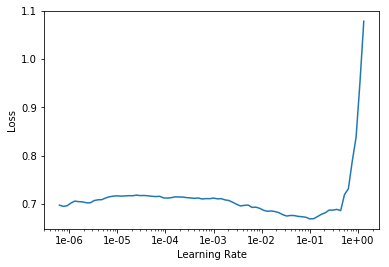

In [11]:
learn.recorder.plot()

In [12]:
# for check, fitting one cycle
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.589318,0.511646,0.752048,10:02


In [13]:
# saving the first model
learn.save('first')

In [6]:
learn.load('first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1420751 items)
x: TextList
xxbos i do n't think we can do our picnic,xxbos i 'm with my steph buddy and we 're so happy not even june and summer already xxup rocks ! xxmaj that and the moon looks amazing look at that . ...,xxbos xxmaj haha , i wonder how many followers xxup that gets me .,xxbos xxmaj there is n't going to be anything happening for some time yet- this is just a warning for all you dying of boredom ! - sorry !,xxbos @meln4 insanely xxrep 4 . everyone is out and the boys have n't twittered in xxup ages lol
y: CategoryList
0,1,1,0,0
Path: /home/roope/projects/sort-by-sentiment/training-data;

Valid: LabelList (157861 items)
x: TextList
xxbos watching the second part of the xxmaj google xxmaj wave demo video . xxmaj in the garden , in the sun , xxup hd quality video , in a lazy chair,xxbos xxunk every time i do my computer says thers been an error ...,xxbos been at home the whole day so bored !,xxbos uploading pictures i

In [7]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.458690,0.379486,0.828495,08:59


In [8]:
learn.save('second')

In [9]:
learn.load('second');

In [10]:

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.388119,0.347371,0.846435,12:46


In [11]:
learn.save('third')


In [12]:
learn.load('third')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1420751 items)
x: TextList
xxbos i do n't think we can do our picnic,xxbos i 'm with my steph buddy and we 're so happy not even june and summer already xxup rocks ! xxmaj that and the moon looks amazing look at that . ...,xxbos xxmaj haha , i wonder how many followers xxup that gets me .,xxbos xxmaj there is n't going to be anything happening for some time yet- this is just a warning for all you dying of boredom ! - sorry !,xxbos @meln4 insanely xxrep 4 . everyone is out and the boys have n't twittered in xxup ages lol
y: CategoryList
0,1,1,0,0
Path: /home/roope/projects/sort-by-sentiment/training-data;

Valid: LabelList (157861 items)
x: TextList
xxbos watching the second part of the xxmaj google xxmaj wave demo video . xxmaj in the garden , in the sun , xxup hd quality video , in a lazy chair,xxbos xxunk every time i do my computer says thers been an error ...,xxbos been at home the whole day so bored !,xxbos uploading pictures i

In [13]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.363583,0.343535,0.849120,19:19
1,0.368113,0.336217,0.852345,19:48
2,0.360237,0.329518,0.856519,19:08
3,0.340924,0.323235,0.859978,19:23
4,0.328941,0.321777,0.861004,20:19
5,0.323112,0.316192,0.863323,19:53
6,0.321990,0.313437,0.865705,18:55
7,0.300894,0.315956,0.865781,19:52
8,0.297706,0.314378,0.866268,19:01
9,0.290770,0.316075,0.866617,19:30


In [14]:
learn.save('final-model')

In [ ]:
# the above model achieved in tenth cycle valid los of 0.316075 and accuracy 86,6617%
#(validation loss went down till 7 cycle. After 8 cycle the validation loss slightly increased, so the model 
# may have overfitted slightly / the last 3 epochs were not that useful) However the accuracy went still up

In [ ]:
# testing prediction

In [15]:
learn.predict("I really loved that movie, it was awesome!")

(Category 1, tensor(1), tensor([0.0051, 0.9949]))

In [16]:
learn.predict("It was okey")

(Category 1, tensor(1), tensor([0.3138, 0.6862]))

In [17]:
learn.predict("i was worried")

(Category 0, tensor(0), tensor([0.9098, 0.0902]))

In [19]:
learn.predict('it was not good')

(Category 0, tensor(0), tensor([0.9787, 0.0213]))

In [20]:
learn.predict('it is not bad')

(Category 1, tensor(1), tensor([0.0569, 0.9431]))